In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [6]:
import scipy.optimize as optimization

import utilities as uts
from BHDVCStf import BHDVCS #modified bhdvcs file
bhdvcs = BHDVCS()

In [10]:
df = pd.read_csv("dvcs_psuedo.csv")
data = uts.DvcsData(df)

In [46]:
numReplicas = 500
results = np.fromfile('Methods/replicas500.txt').reshape(15, 500, 3)

## Model

In [39]:
def produceEstimates(replica_models, valid_x):
    cffGuesses = []
    for model in replica_models:
        cffGuesses.append(model.predict(valid_x)[0][0])
    return np.array(cffGuesses)

In [40]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="relu")(kinematics)
outputs = tf.keras.layers.Dense(1)(x)

globalModel = tf.keras.Model(inputs=kinematics, outputs=outputs, name="GlobalModel")

In [41]:
whichCFF = 0 # ReH
numSets = 15

X = df.loc[np.array(range(numSets))*36, ['k', 'QQ', 'x_b', 't']].reset_index(drop=True)

y = df.loc[np.array(range(numSets))*36, 'ReH'].reset_index(drop=True)

rescaler = MinMaxScaler()

rescaler = rescaler.fit(X)

X_rescaled = rescaler.transform(X)

globalModel.compile(optimizer=tf.keras.optimizers.Adam(.3), loss=tf.keras.losses.MeanSquaredError())

orig_weights = globalModel.get_weights()

In [42]:
def gen_to_pred(data, resolution=100):
    km = np.repeat([data.Kinematics['k'].median()], resolution)
    QQm = np.repeat([data.Kinematics['QQ'].median()], resolution)
    x_bm = np.repeat([data.Kinematics['x_b'].median()], resolution)
    tm = np.repeat([data.Kinematics['t'].median()], resolution)

    k = np.linspace(data.Kinematics['k'].min(), data.Kinematics['k'].max(), num=resolution)
    QQ = np.linspace(data.Kinematics['QQ'].min(), data.Kinematics['QQ'].max(), num=resolution)
    x_b = np.linspace(data.Kinematics['x_b'].min(), data.Kinematics['x_b'].max(), num=resolution)
    t = np.linspace(data.Kinematics['t'].min(), data.Kinematics['t'].max(), num=resolution)
    
    to_pred = np.column_stack([k, QQm, x_bm, tm])
    to_pred = np.vstack([to_pred, np.column_stack([km, QQ, x_bm, tm])])
    to_pred = np.vstack([to_pred, np.column_stack([km, QQm, x_b, tm])])
    to_pred = np.vstack([to_pred, np.column_stack([km, QQm, x_bm, t])])
    
    return to_pred, k, QQ, x_b, t

In [43]:
to_pred, k, QQ, x_b, t = gen_to_pred(data)

In [44]:
def predictwReplicas(model, X, to_pred, results, orig_weights, numReplicas, whichCFF):
    #valid_y = np.array(y[i])

    preds = []
    for rep in tqdm(range(numReplicas)):
        
        train_y = results[:, rep, whichCFF]

        model.set_weights(orig_weights)
        model.fit(X, train_y, epochs = 150, verbose=0)
        preds.append(model.predict(to_pred))
        
    return np.column_stack(preds)

In [47]:
preds = predictwReplicas(globalModel, X_rescaled, to_pred, results, orig_weights, numReplicas, whichCFF)

In [48]:
def c_int_plot(preds, x, which_kin, kin_range, cffname):
    '''
    :param preds: numpy array of predictions
    :param x: an array of the values of which_kin that were used in generating predictions
    :param which_kin: string name of kinematic to plot
    :param kin_range: a tuple of lower and upper indices of predictions
    :param cffname: the name of the compton form factor we're predicting
    '''
    y_hat = preds[kin_range[0]:kin_range[1], :].mean(axis=1)
    upper_y_hat = y_hat + preds[kin_range[0]:kin_range[1], :].std(axis=1)
    lower_y_hat = y_hat - preds[kin_range[0]:kin_range[1], :].std(axis=1)
    
    plt.plot(x, lower_y_hat)
    plt.plot(x, y_hat, color='black')
    plt.plot(x, upper_y_hat, color='red')
    plt.title('68% confidence interval with point predictions')
    plt.ylabel(cffname)
    plt.xlabel(which_kin)
    plt.show()
        

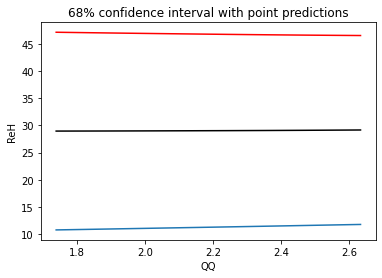

In [55]:
c_int_plot(preds, QQ, 'QQ', (100, 200), 'ReH')